In [1]:
import gymnasium as gym
import pandas as pd
import numpy as np
import pandas_ta as ta
import gym_trading_env
import datetime
import matplotlib
import matplotlib.pyplot as plt
from gym_trading_env.downloader import download
from time import time

from stable_baselines3 import A2C

In [2]:
# Constants
DIR = "../../data"
SYMBOL = "SUI/USDT" # you can change to any other symbol
TIMEFRAME = "5m" # 5m 15m 1h 4h 1d 1w 1M
EXCHANGE = "binance" # bitget binance bitfinex bitmex bitstamp coinbasepro huobi kraken kucoin okex
DISCORD_WEBHOOK_URL = ""

In [3]:
# Download BTC/USDT historical data from Binance and stores it to directory ./data/binance-BTCUSDT-1h.pkl
download(exchange_names = [EXCHANGE],
    symbols= [SYMBOL],
    timeframe= TIMEFRAME,
    dir = DIR,
    since= datetime.datetime(year= 2023, month= 11, day= 11),
)
# Import your fresh data
df = pd.read_pickle(DIR+"/"+EXCHANGE+"-"+SYMBOL.replace("/","")+"-"+TIMEFRAME+".pkl")

SUI/USDT downloaded from binance and stored at ../../data/binance-SUIUSDT-5m.pkl


In [4]:
# Handle more feature
df['feature_open'] = df['open']
df['feature_high'] = df['high']
df['feature_low'] = df['low']
df['feature_close'] = df['close']
df['feature_volume'] = df['volume']
df['feature_close_pct_change'] = df['close'].pct_change()
df['feature_volume_pct_change'] = df['volume'].pct_change()
df['feature_shift_1_close'] = df['close'].shift(1)
df['feature_shift_1_open'] = df['open'].shift(1)
df['feature_shift_1_volume'] = df['volume'].shift(1)
df['feature_shift_2_close'] = df['close'].shift(2)
df['feature_shift_2_open'] = df['open'].shift(2)
df['feature_shift_2_volume'] = df['volume'].shift(2)
df['feature_shift_3_close'] = df['close'].shift(3)
df['feature_shift_3_open'] = df['open'].shift(3)
df['feature_shift_3_volume'] = df['volume'].shift(3)
df['feature_shift_4_close'] = df['close'].shift(4)
df['feature_shift_4_open'] = df['open'].shift(4)
df['feature_shift_4_volume'] = df['volume'].shift(4)
df['feature_shift_5_close'] = df['close'].shift(5)
df['feature_shift_5_open'] = df['open'].shift(5)
df['feature_shift_5_volume'] = df['volume'].shift(5)
df['feature_LONGLINE'] = df.ta.cdl_pattern(name="longline")['CDL_LONGLINE']
df['feature_HIKKAKE'] = df.ta.cdl_pattern(name="hikkake")['CDL_HIKKAKE']
df['feature_HARAMICROSS'] = df.ta.cdl_pattern(name="haramicross")['CDL_HARAMICROSS']
temp = df.ta.macd()
df['feature_MACD'] = temp['MACD_12_26_9']   
df['feature_MACD_SIGNAL'] = temp['MACDs_12_26_9']
df['feature_MACD_HIST'] = temp['MACDh_12_26_9']
df['feature_RSI'] = df.ta.rsi()
df['feature_VWAP'] = df.ta.vwap()
df['feature_MASSI'] = df.ta.massi()
df['feature_ATR'] = df.ta.atr()
df['feature_CKSPL'] = df.ta.cksp()['CKSPl_10_3_20']
df['feature_CKSPS'] = df.ta.cksp()['CKSPs_10_3_20']
df['feature_ADX'] = df.ta.adx()['ADX_14']
df = df.drop(columns=['date_close'])
df = df.dropna()

In [5]:
def reward_func(history):
    # history is a list of actions
    # return a reward value
    last_reward = history['reward', -1] # change + reward
    reward_score = np.log(history["portfolio_valuation", -1] / history["portfolio_valuation", -2]) 
    if reward_score > 0:reward_score += reward_score * 0.5
    else:reward_score -= reward_score * 0.1
    return reward_score + last_reward

In [6]:
# need to switch to custom env
env = gym.make("TradingEnv", df = df, positions = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1], initial_position= 0, trading_fees = 0.02/100, reward_function = reward_func)

env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Lenght', lambda history : len(history['position']) )
env.unwrapped.add_metric('Win Rate', lambda history : np.sum(history['reward'] > 0) / len(history['reward']) )

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [7]:
from stable_baselines3.common.callbacks import BaseCallback

history = {
    "portfolio_return": [],
    "win rate": [],
    "position changes": [],
}

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        if 'done' in self.locals and self.locals['done']:
            history['portfolio_return'].append(float(env.unwrapped.get_metrics()['Portfolio Return'].replace("%","")))
            history['win rate'].append(env.unwrapped.get_metrics()['Win Rate'])
            history['position changes'].append(env.unwrapped.get_metrics()['Position Changes'])
        return True


In [8]:
model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=100000, callback=CustomCallback())

Market Return : 17.42%   |   Portfolio Return : -60.48%   |   Position Changes : 3751   |   Episode Lenght : 4270   |   Win Rate : 0.4278688524590164   |   
Market Return : 17.42%   |   Portfolio Return : -50.78%   |   Position Changes : 3296   |   Episode Lenght : 4270   |   Win Rate : 0.46533957845433255   |   
Market Return : 17.42%   |   Portfolio Return : -39.78%   |   Position Changes : 1797   |   Episode Lenght : 4270   |   Win Rate : 0.4791569086651054   |   
Market Return : 17.42%   |   Portfolio Return : -40.23%   |   Position Changes : 1587   |   Episode Lenght : 4270   |   Win Rate : 0.4793911007025761   |   
Market Return : 17.42%   |   Portfolio Return : -29.57%   |   Position Changes : 1169   |   Episode Lenght : 4270   |   Win Rate : 0.48149882903981267   |   
Market Return : 17.42%   |   Portfolio Return : -32.98%   |   Position Changes : 1475   |   Episode Lenght : 4270   |   Win Rate : 0.47704918032786886   |   
Market Return : 17.42%   |   Portfolio Return : -30.97%

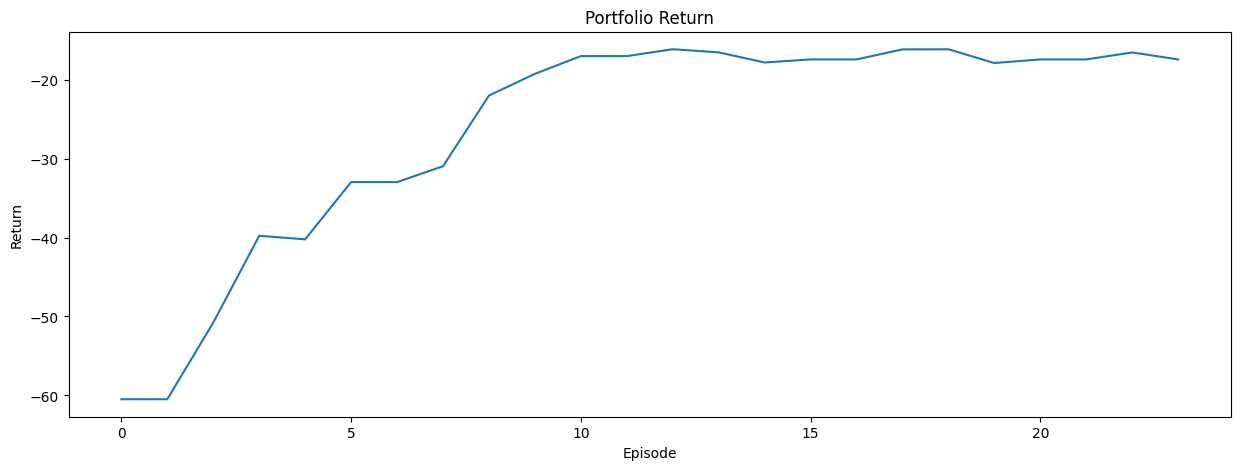

In [9]:
# Plotting
plt.figure(figsize=(15,5))
plt.plot(history['portfolio_return'])
plt.title('Portfolio Return')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

In [10]:
history_rewards = env.unwrapped.historical_info['reward']
plt.figure(figsize=(15,5))
plt.plot(history_rewards)
plt.title('Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['win rate'])
plt.title('Win Rate')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['position changes'])
plt.title('Position Changes')
plt.xlabel('Episode')
plt.ylabel('Position Changes')
plt.show()

In [ ]:
template = """
====================
|  AI Trading Bot  |
====================
Training Complete
====================

Trading Symbol: {symbol}
Timeframe: {timeframe}
Exchange: {exchange}
Portfolio Return: {return_value} %
Training Time: {time} minutes
"""


if DISCORD_WEBHOOK_URL:
    import requests

    # Text result

    mertics_metadata:dict = env.unwrapped.get_metrics()
    mertics_metadata.pop('Portfolio Return')
    mertics_data = [f"{key}: {value}" for key, value in mertics_metadata.items()]

    template += "\n".join(mertics_data)

    data = {
        "content": template.format(
            return_value = Portfolio_Return.replace("%",""),
            time = (end_time - start_time)/60,
            symbol = SYMBOL,
            timeframe = TIMEFRAME,
            exchange = EXCHANGE
        ),
        "username": "AI Trader Notification",
        "avatar_url": "https://i.imgur.com/4bY31Fb.jpg"
    }

    r = requests.post(DISCORD_WEBHOOK_URL, data=data)

    if r.status_code != 204:
        print(f"Discord Webhook returned status code {r.status_code}")
    else:
        print("Discord Webhook Sent")

In [ ]:
template = """
====================
Result Image
====================
"""

if DISCORD_WEBHOOK_URL:
    # image result

    files = {
        "file": ("result.png", open("result.png", "rb"))
    }

    data = {
        "content": template,
        "username": "AI Trader Notification",
        "avatar_url": "https://i.imgur.com/4bY31Fb.jpg"
    }

    r = requests.post(DISCORD_WEBHOOK_URL, data=data, files=files)

    if r.status_code != 200:
        print(f"Discord Webhook returned status code {r.status_code}")
    else:
        print("Discord Webhook Sent")